# 13 RNA velocity TBI

## Notebook setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import warnings, scipy.sparse as sp, matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.pyplot import rc_context
from collections import Counter
import matplotlib.font_manager
import openpyxl
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
#import magic
#import seaborn as sns
import palantir
import loompy
import feather
import re
#from scipy.sparse import csgraph

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rc('font', size=14)
import matplotlib.lines as lines

pd.set_option('display.max_rows', 200)

sc.set_figure_params(dpi=80, dpi_save=300, color_map='Spectral_r', vector_friendly=True, transparent=True)
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.5.3 pandas==1.4.4 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


In [2]:
user_defined_palette =  [ '#F6222E', '#FEAF16','#3283FE','#BDCDFF', '#3B00FB', '#F8A19F', '#1CFFCE',  '#C4451C', 
                          '#2ED9FF', '#c1c119', '#8b0000', '#FE00FA', '#1CBE4F','#B5EFB5', '#0e452b', '#AA0DFE']

In [3]:
user_defined_cmap_markers = LinearSegmentedColormap.from_list('mycmap', ["#E6E6FF", "#CCCCFF", "#B2B2FF", "#9999FF",  "#6666FF",   "#3333FF", "#0000FF"])
user_defined_cmap_degs = LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#3333FF", "#6666FF", "#9999FF", "#B2B2FF", "#CCCCFF", "#E6E6FF", "#E6FFE6", "#CCFFCC", "#B2FFB2", "#99FF99", "#66FF66", "#33FF33", "#00FF00"])

In [4]:
%matplotlib inline 

## Load data for Fig 5

In [5]:
path_to_h5ad = '../output/anndata_io/Fig5ij.h5ad'

In [6]:
adata_d0147 = sc.read_h5ad(path_to_h5ad)
adata_d0147.uns['log1p']["base"] = None

## Include looms

In [7]:
import scvelo as scv
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True, format='pdf')

In [8]:
from pathlib import Path

ds_list = []

tenexdir = '../data/internal/10xGenomics/'
loom_path = Path(tenexdir).glob('**/**/**/**/cr-results.loom')

with loompy.new('loom_merged.loom') as dsout:  # Create a new, empty, loom file
    for f in loom_path:
        with loompy.connect(f) as ds:
            totals = ds.map([np.sum], axis=1)[0]
            cells = np.where(totals > 0)[0] # Select the cells that passed QC (totals > 500)
            ds_list.append(ds.shape[1])
            for (ix, selection, view) in ds.scan(items=cells, axis=1):
                dsout.add_columns(view.layers, col_attrs=view.ca, row_attrs=view.ra)

In [9]:
ldata = scv.read('loom_merged.loom', cache=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [10]:
x = np.repeat(np.array([ '-1@mo02_CD45neg1_d4',  '-1@mo02_CD45neg1_d0', '-1@mo02_CD45neg2_d7', '-1@mo02_FB_d1', 
                         '-1@mo02_CD45neg2_d1', '-1@mo02_EC_d7', '-1@mo02_EC_d4', '-1@mo02_FB_d7', 
                         '-1@mo02_EC_d1', '-1@mo02_EC_d0', '-1@mo02_FB_d4', '-1@mo02_CD45neg2_d4',  
                         '-1@mo02_CD45neg2_d0', '-1@mo02_CD45neg1_d7', '-1@mo02_CD45neg1_d1', '-1@mo02_FB_d0',
                         '-1@mo18_EC_d1', '-1@mo18_FB_d1', '-1@mo18_CD45neg_d4', '-1@mo18_CD45neg1_d0',
                         '-1@mo18_EC_d4', '-1@mo18_FB_d4', '-1@mo18_CD45neg2_d0', '-1@mo18_CD45neg_d7',
                         '-1@mo18_CD45neg_d1', '-1@mo18_EC_d7', '-1@mo18_EC_d0', '-1@mo18_FB_d7', 
                         '-1@mo18_FB_d0']), ds_list, axis=0)

In [11]:
ldata.obs['name_match'] = x

In [12]:
start = ':'
end = 'x'

barcodes = []
for loom_index in ldata.obs_names:
    barcodes.append(str(loom_index[loom_index.find(start)+len(start):loom_index.rfind(end)]))
ldata.obs['barcodes'] = barcodes

In [13]:
ldata.obs_names = ldata.obs[['barcodes','name_match']].agg(''.join, axis=1)

In [14]:
from collections import Counter
[k for k, v in Counter(ldata.obs_names).items() if v > 1]

[]

In [15]:
TEC_d0147 = adata_d0147[(adata_d0147.obs['cell_type_subset']=='10:aaTEC1') | (adata_d0147.obs['cell_type_subset']=='11:aaTEC2') | (adata_d0147.obs['cell_type_subset']=='12:cTEC') | (adata_d0147.obs['cell_type_subset']=='12:early Pr') |
                        (adata_d0147.obs['cell_type_subset']=='13:mTEC1') | (adata_d0147.obs['cell_type_subset']=='14:mTEC-prol') | (adata_d0147.obs['cell_type_subset']=='15:mTEC2') |
                        (adata_d0147.obs['cell_type_subset']=='16:mimetic(basal)') | (adata_d0147.obs['cell_type_subset']=='17:mimetic(tuft)') | (adata_d0147.obs['cell_type_subset']=='18:mimetic(neuroendo)') |
                        (adata_d0147.obs['cell_type_subset']=='19:mimetic(goblet)') | (adata_d0147.obs['cell_type_subset']=='20:mimetic(microfold)')]

In [16]:
# Remove columns with all 0s
sc.pp.filter_genes(TEC_d0147, min_cells=1)

filtered out 738 genes that are detected in less than 1 cells


#### Identify highly variable genes (all samples but day 1) and replot the data

In [17]:
TEC_d047 = TEC_d0147[TEC_d0147.obs['day']!='d1']

In [18]:
# Remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(TEC_d047, min_cells=1)

filtered out 631 genes that are detected in less than 1 cells


In [19]:
sc.pp.highly_variable_genes(TEC_d047, n_top_genes=3500, flavor='seurat')

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [20]:
hvgs = TEC_d047.var[TEC_d047.var['highly_variable']==True].index

In [21]:
TEC_d047.var['highly_variable'] = ''

In [22]:
TEC_d0147.var['highly_variable'] = [True if x in hvgs else False for x in TEC_d0147.var['highly_variable'].index]

In [23]:
rng = np.random.RandomState(42)
sc.tl.pca(TEC_d0147, n_comps=55, svd_solver='arpack', random_state=rng, use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=55
    finished (0:00:01)


In [24]:
sce.pp.harmony_integrate(TEC_d0147, 'sample')

2024-04-16 13:33:21,635 - harmonypy - INFO - Iteration 1 of 10
2024-04-16 13:33:23,962 - harmonypy - INFO - Iteration 2 of 10
2024-04-16 13:33:26,423 - harmonypy - INFO - Iteration 3 of 10
2024-04-16 13:33:28,746 - harmonypy - INFO - Iteration 4 of 10
2024-04-16 13:33:31,032 - harmonypy - INFO - Converged after 4 iterations


In [25]:
sc.pp.neighbors(TEC_d0147, n_neighbors=15, use_rep='X_pca_harmony')
sc.tl.umap(TEC_d0147)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [26]:
TEC_d0147.uns['cell_type_subset_colors'] = [ '#2ED9FF', '#c1c119',  '#8b0000','#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7' ,'#FEAF16', '#325A9B', '#C075A6']

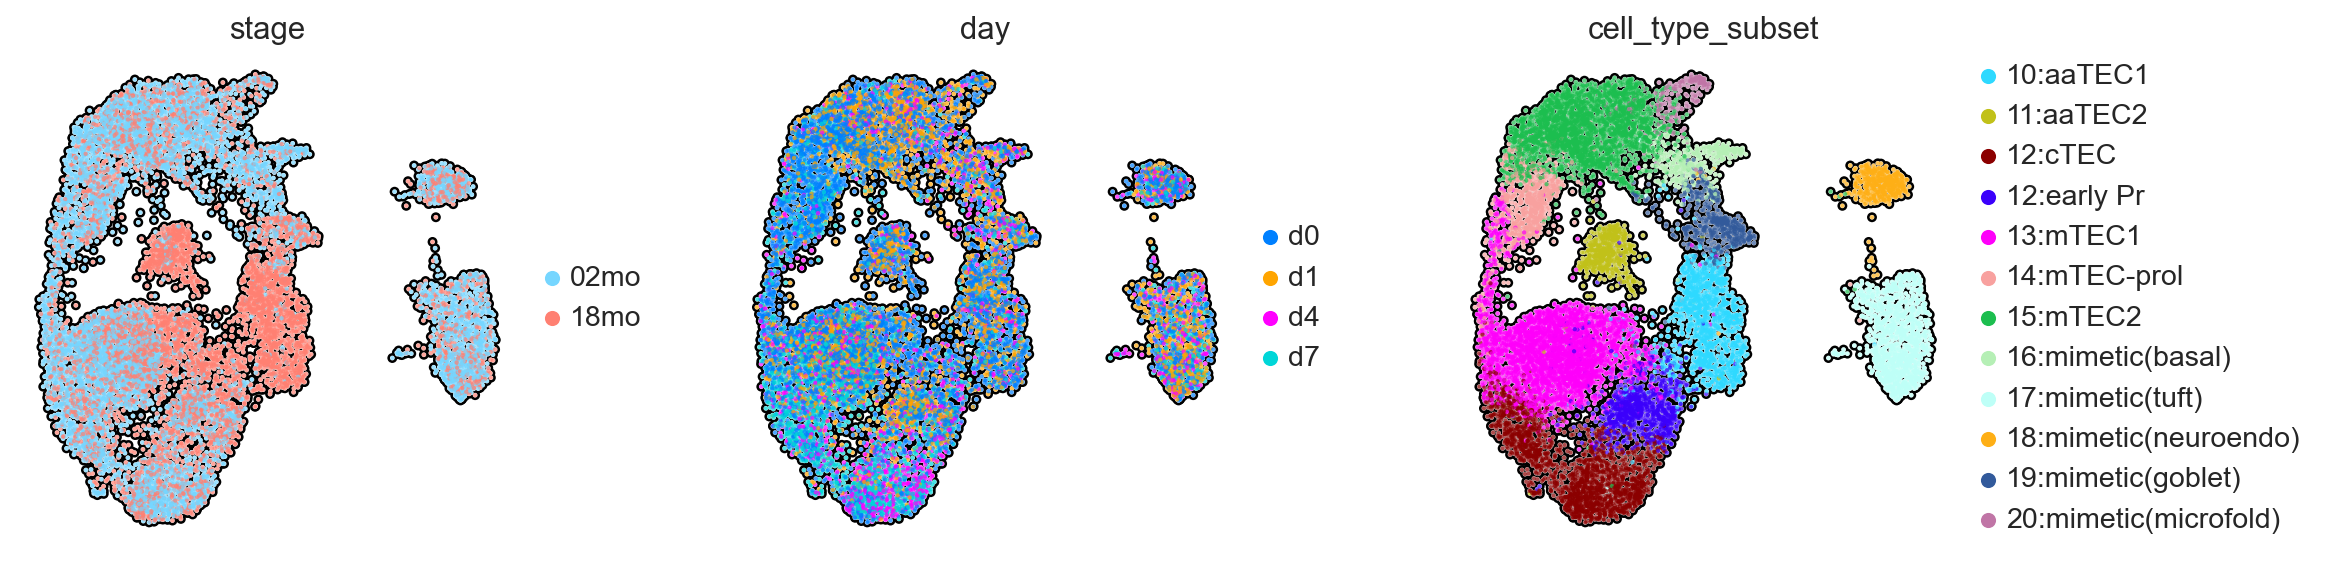

In [27]:
#55
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

sc.pl.umap(
    TEC_d0147, 
    color=['stage', 'day', 'cell_type_subset'], 
    ncols=6,
    outline_width=[0.6, 0.05],
    size=15,
    frameon=False,
    cmap='Spectral_r',
    wspace = 0.3,
    add_outline=True
)

In [28]:
path_to_h5ad = '../output/anndata_io/Fig5j.h5ad'

In [29]:
TEC_d0147.write(path_to_h5ad)

## RNA velocity

In [30]:
TEC_d0147_loom = scv.utils.merge(TEC_d0147, ldata)

In [31]:
TEC_d0147_loom.shape

(14056, 28014)

In [32]:
scv.tl.velocity(TEC_d0147_loom, mode='stochastic')

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:12) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:45) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [33]:
scv.tl.velocity_graph(TEC_d0147_loom, n_jobs=7)

computing velocity graph (using 7/8 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:46) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


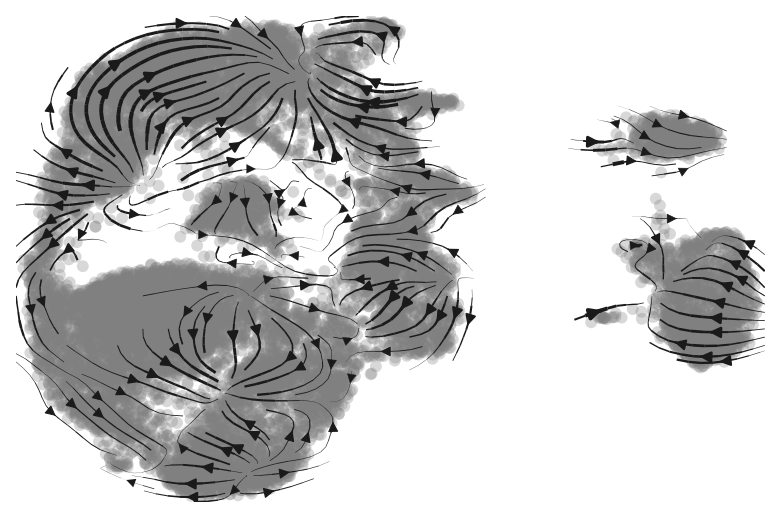

In [34]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap')

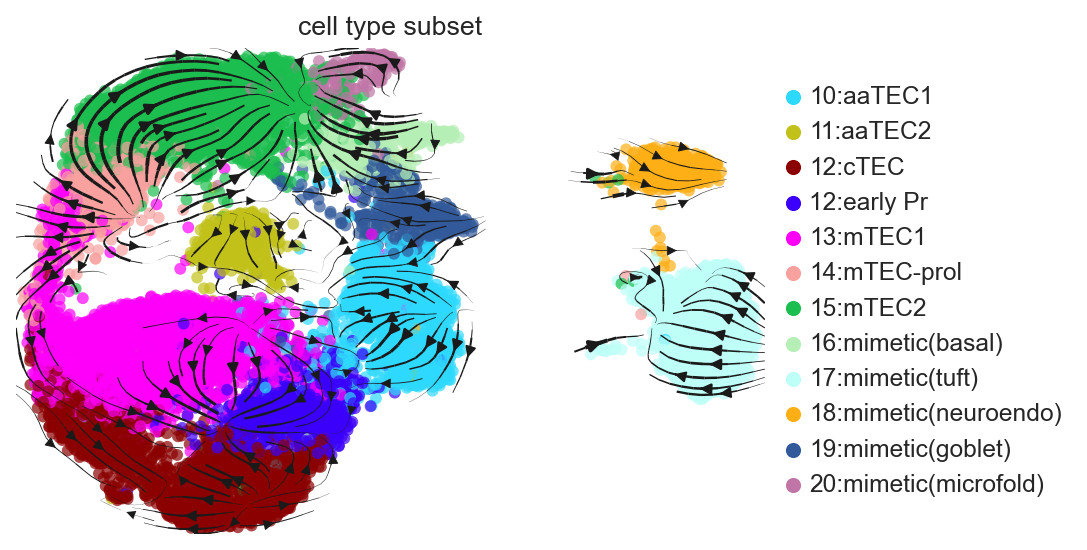

In [35]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', color=['cell_type_subset'],alpha=0.7, legend_loc='right')

In [36]:
TEC_d0147_loom.obs['distinct'] = ''
TEC_d0147_loom.obs['distinct'] = TEC_d0147_loom.obs[['stage', 'day', 'cell_type_subset']].agg(' '.join, axis=1)

In [37]:
TEC_d0147_loom.uns['distinct_colors'] = ['#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#BEFFF7','#FEAF16', '#325A9B', '#C075A6',
                                         '#2ED9FF', '#c1c119', '#8b0000', '#3B00FB', '#FE00FA', "#F8A19F", '#1CBE4F','#B5EFB5',  '#AA0DFE','#BEFFF7', '#325A9B', '#C075A6']

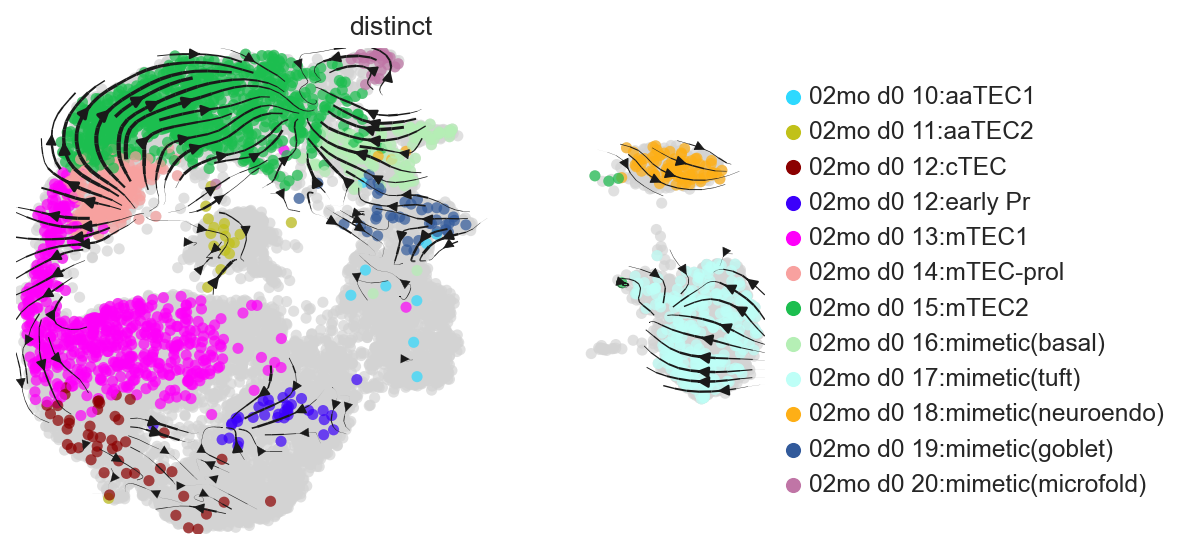

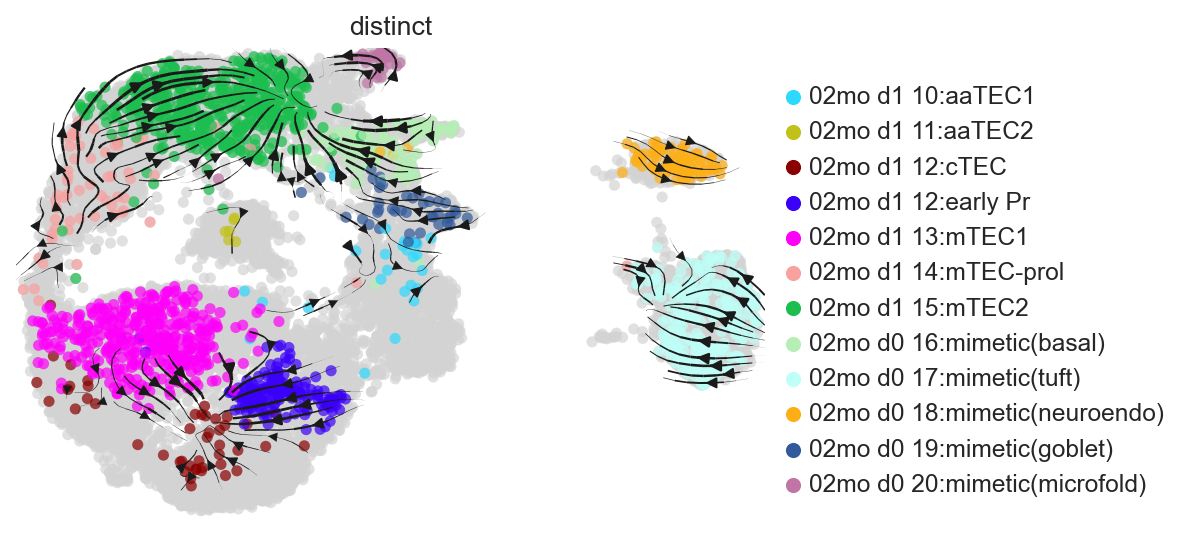

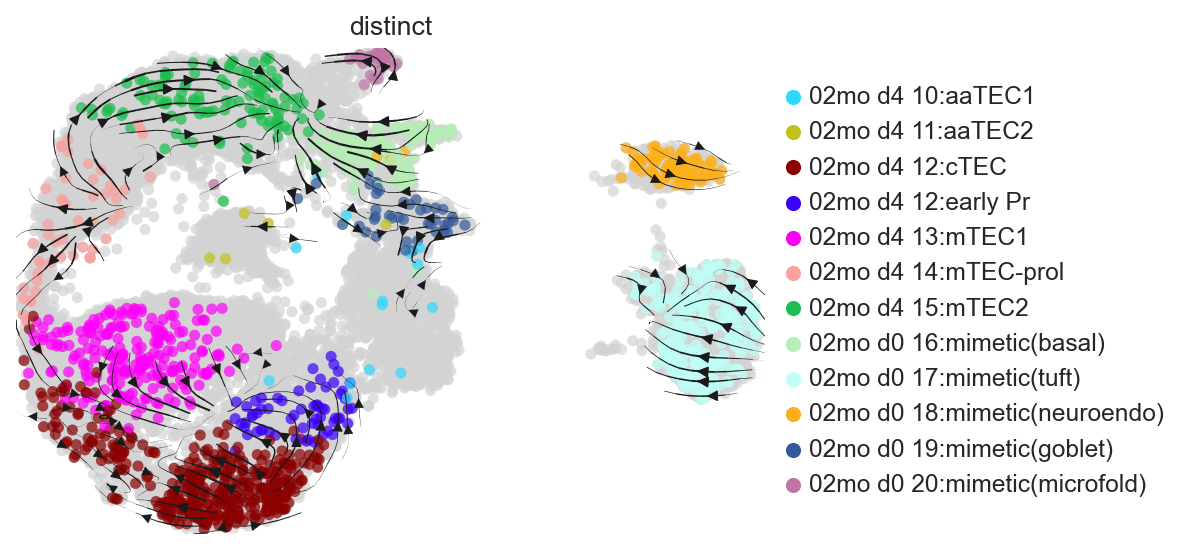

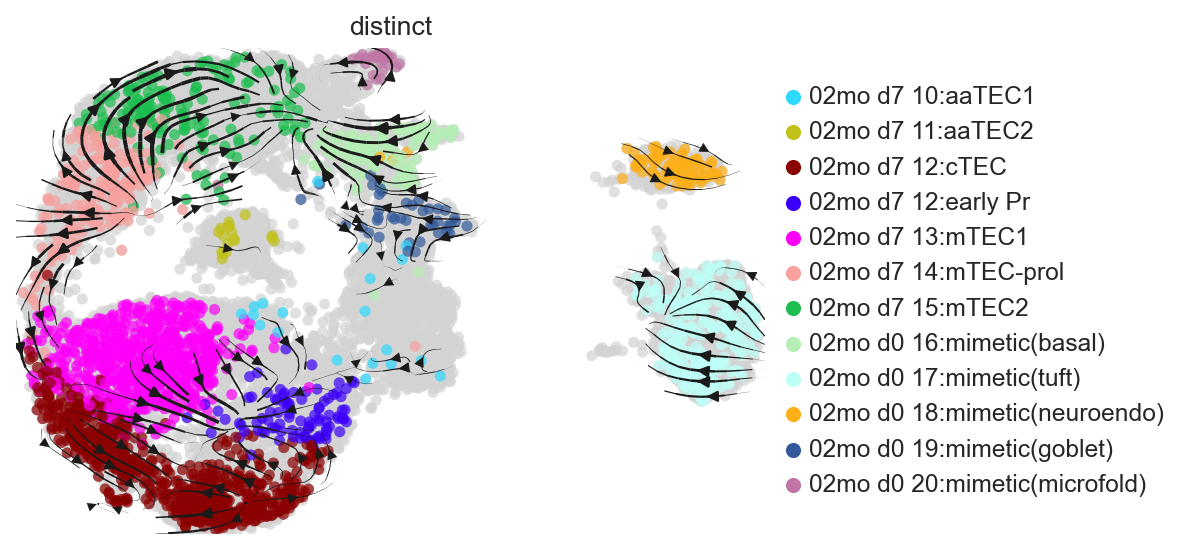

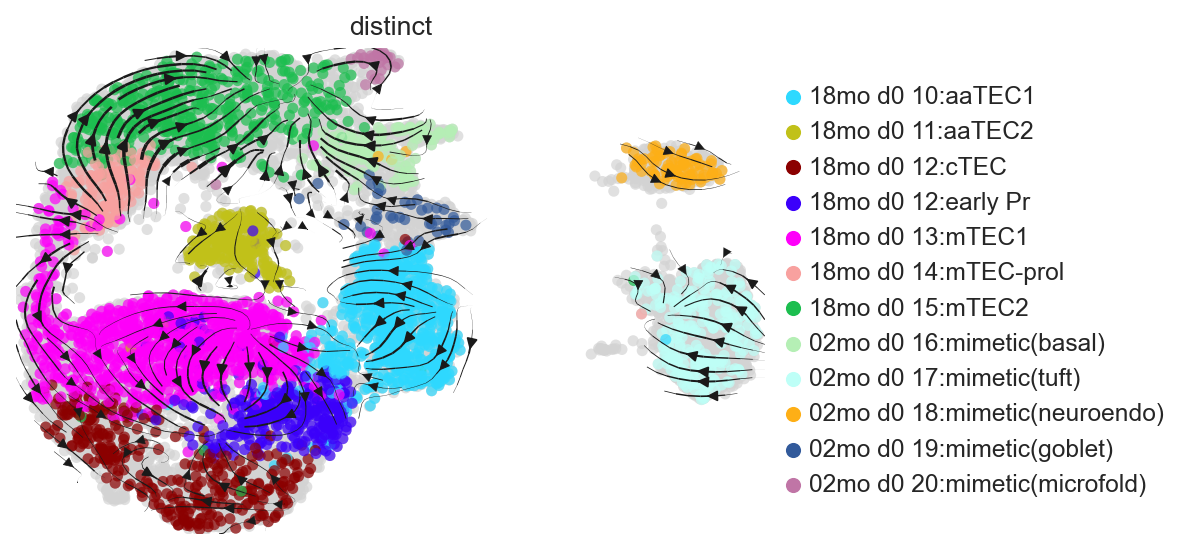

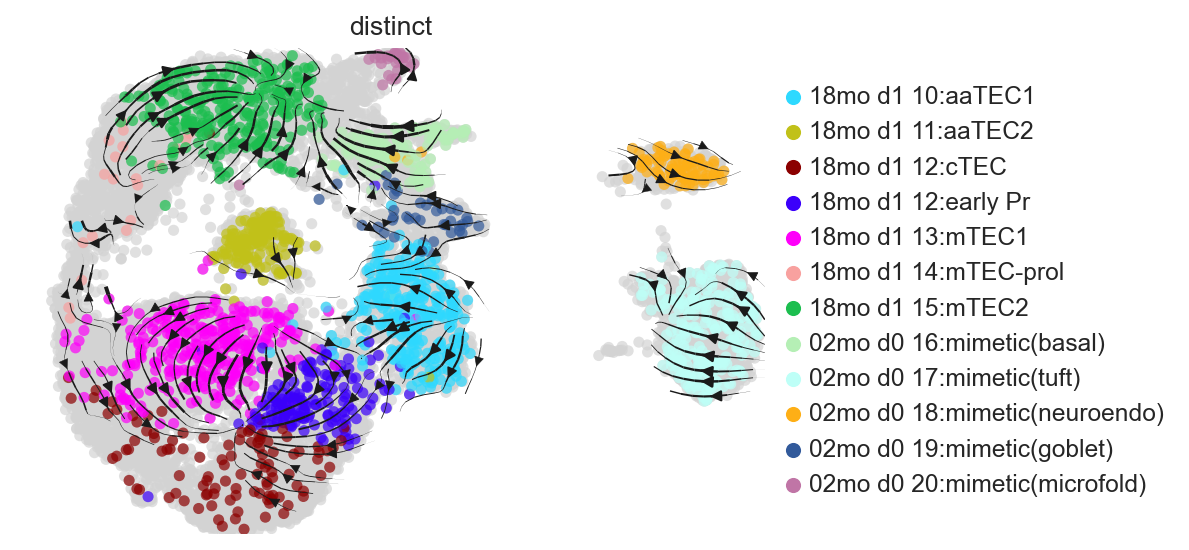

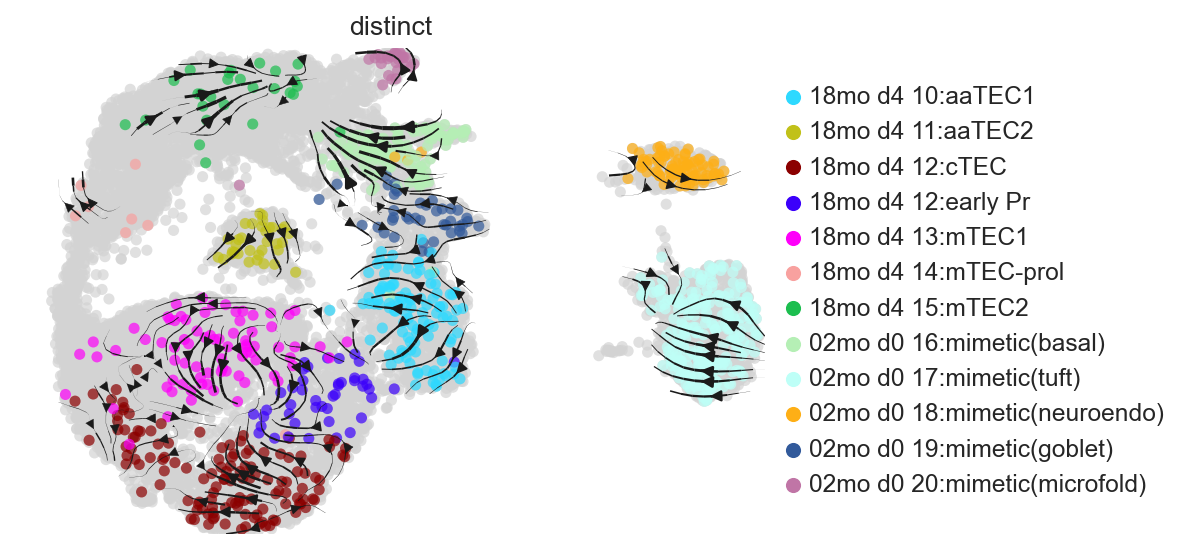

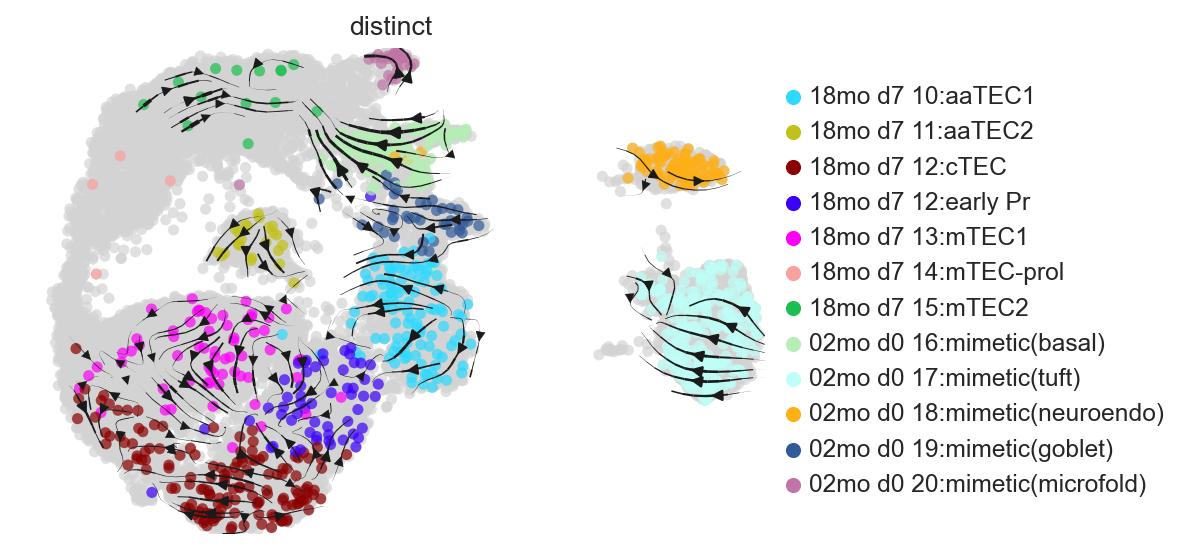

In [38]:
scv.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=True, transparent=True)

scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['02mo d0 10:aaTEC1', '02mo d0 11:aaTEC2', '02mo d0 12:cTEC',  '02mo d0 12:early Pr', '02mo d0 13:mTEC1', '02mo d0 14:mTEC-prol', '02mo d0 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['02mo d1 10:aaTEC1', '02mo d1 11:aaTEC2', '02mo d1 12:cTEC',  '02mo d1 12:early Pr', '02mo d1 13:mTEC1', '02mo d1 14:mTEC-prol', '02mo d1 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['02mo d4 10:aaTEC1', '02mo d4 11:aaTEC2', '02mo d4 12:cTEC',  '02mo d4 12:early Pr', '02mo d4 13:mTEC1', '02mo d4 14:mTEC-prol', '02mo d4 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['02mo d7 10:aaTEC1', '02mo d7 11:aaTEC2', '02mo d7 12:cTEC',  '02mo d7 12:early Pr', '02mo d7 13:mTEC1', '02mo d7 14:mTEC-prol', '02mo d7 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['18mo d0 10:aaTEC1', '18mo d0 11:aaTEC2', '18mo d0 12:cTEC',  '18mo d0 12:early Pr', '18mo d0 13:mTEC1', '18mo d0 14:mTEC-prol', '18mo d0 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['18mo d1 10:aaTEC1', '18mo d1 11:aaTEC2', '18mo d1 12:cTEC',  '18mo d1 12:early Pr', '18mo d1 13:mTEC1', '18mo d1 14:mTEC-prol', '18mo d1 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['18mo d4 10:aaTEC1', '18mo d4 11:aaTEC2', '18mo d4 12:cTEC',  '18mo d4 12:early Pr', '18mo d4 13:mTEC1', '18mo d4 14:mTEC-prol', '18mo d4 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')
scv.pl.velocity_embedding_stream(TEC_d0147_loom, basis='umap', groups=['18mo d7 10:aaTEC1', '18mo d7 11:aaTEC2', '18mo d7 12:cTEC',  '18mo d7 12:early Pr', '18mo d7 13:mTEC1', '18mo d7 14:mTEC-prol', '18mo d7 15:mTEC2', '02mo d0 16:mimetic(basal)', '02mo d0 17:mimetic(tuft)', '02mo d0 18:mimetic(neuroendo)', '02mo d0 19:mimetic(goblet)', '02mo d0 20:mimetic(microfold)'], color='distinct', size=100, alpha=0.7, legend_loc='right')

In [39]:
path_to_h5ad = '../output/anndata_io/Fig5k.h5ad'

In [40]:
TEC_d0147_loom.write(path_to_h5ad)